In [1]:
import os
os.chdir('../')

import sys
sys.path.append('src/')

In [2]:
import warnings
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv

from base import logger
from base.commons import load_yaml, load_json, dump_json, dump_yaml, dump_pickle, load_pickle
from model.data import extract_scrapped_relational_data
from report import generate_eda_report
from report.preprocessing import supervised_test_rf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


from auto_preprocess import AutoPreProcessor, Clipper, CategoricalDropper
from auto_preprocess.config import *

from model.data.external import add_external_data
from model.features import feature_engineering
from model.artifacts import update_model_artifacts
from model.hyperparameter_tunning import HyperparameterTunner

%config IPCompleter.use_jedi=False

pd.options.display.max_columns = None

warnings.filterwarnings('ignore')

assert load_dotenv()

assert logger.set()

### Funções

### Parâmetros

In [3]:
# Importando variáveis globais
filepaths = load_yaml(os.getenv("FILEPATHS"))
variables = load_yaml(os.getenv("VARIABLES"))

# Configurações
features_config = get_config(os.getenv("FEATURES_CONFIG"))

# Extração de dados: consulta o banco e persite localmente
if variables["extract_data"]:
    extract_scrapped_relational_data()

# Importando dataframe base
df = pd.read_parquet(filepaths["raw_data_relational_scrapped"],)

#Filtrando apenas as casas
df = df.loc[df['type'].isin(variables['estate_types'])]

# Adicionando dados externos
df = df.pipe(add_external_data)

# Separando target de features
X, y = df.drop(columns = variables["target_column"]), df[variables["target_column"]]

# Separando entre teste e treino
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = variables["test_size"], random_state=variables["random_state"]
)

#-- Building features ------------------
X_train_fe = feature_engineering(X_train)

# -- Training preprocessor ------------------
preprocessor = AutoPreProcessor(features_config)
preprocessor.fit(X_train_fe, y_train)

# -- Transforming train dataset ------------------
X_train_transf = preprocessor.transform(X_train_fe)

# -- Transforming test dataset ------------------
X_test_transf = X_test.pipe(feature_engineering).pipe(preprocessor.transform)

# -- EDA Report ------------------


## Testes de Regressores

In [6]:
from sklearn.model_selection import cross_validate

In [82]:
class Mean:
    def __init__(self, iterable, precision=2, verbose = 0):
        self.iterable = iterable
        self.precision = precision
        self.verbose = verbose
        self.mean, self.std = self.evaluate()
        
        if self.verbose > 0:
            print(self)
        
    def __str__(self):
        return "{} ± {}".format(self.mean, self.std)
        
    def __repr__(self):
        return "{} ± {}".format(self.mean, self.std)
        
    def evaluate(self):
        self.mean = np.mean(self.iterable)
        self.std = np.std(self.iterable)
        return np.round(self.mean, self.precision), np.round(self.std, self.precision)
    
    def __abs__(self):
        return "{} ± {}".format(np.abs(self.mean), np.abs(self.std))

In [83]:
var = Mean([1,2,3], verbose=1)

2.0 ± 0.82


In [84]:
abs(var)

'2.0 ± 0.82'

### Dummy Regressor

In [85]:
def eval_average_metric(estimator, X, y, scoring, cv=10, precision=5):
    
    cv_scores = cross_validate(estimator, X, y, scoring=scoring, cv=cv)['test_score']
    
    return Mean(cv_scores, precision=precision)

##################################################
1)  DummyRegressor
R2 = -0.0 ± 0.0
MAE = 394687.0 ± 19438.0


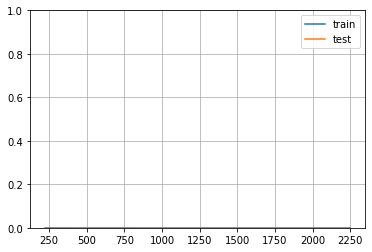



##################################################
2)  LinearRegression
R2 = 0.76 ± 0.03
MAE = 168949.0 ± 13127.0


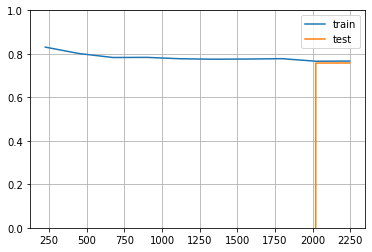



##################################################
3)  DecisionTreeRegressor
R2 = 0.78 ± 0.06
MAE = 116934.0 ± 14053.0


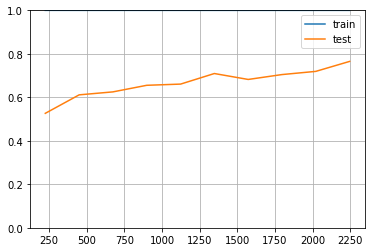



##################################################
4)  RandomForestRegressor
R2 = 0.86 ± 0.02
MAE = 104084.0 ± 9324.0


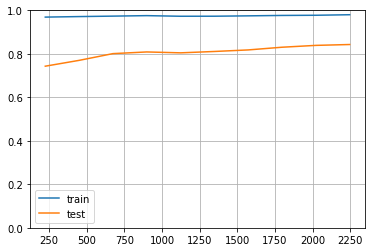



##################################################
5)  GradientBoostingRegressor
R2 = 0.83 ± 0.02
MAE = 137271.0 ± 10881.0


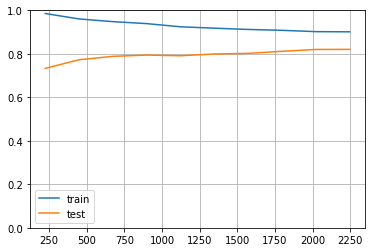



##################################################
6)  LGBMRegressor
R2 = 0.74 ± 0.04
MAE = 157540.0 ± 14405.0


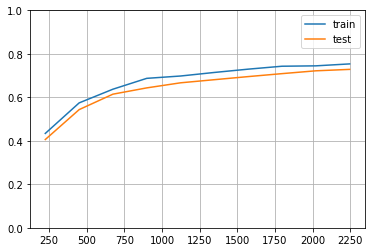



##################################################
7)  XGBRegressor
R2 = 0.85 ± 0.04
MAE = 113224.0 ± 11991.0


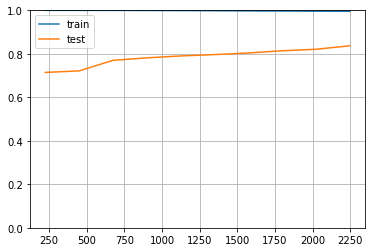

In [197]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

regressors_list = [
    DummyRegressor(),
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    LGBMRegressor(reg_lambda = 1*10**3),
    XGBRegressor(),
]

for i, estimator in enumerate(regressors_list):

    r2 = eval_average_metric(estimator, X_train_transf, y_train, scoring='r2', cv=10, precision=2)

    mae = abs(
        eval_average_metric(
            estimator, 
            X_train_transf, 
            y_train, 
            scoring='neg_mean_absolute_error', 
            cv=10, 
            precision=0
        )
    )

    print(50*"#")
    print(f"{i+1}) ",estimator.__class__.__name__)
    print('R2 = %s' % r2)
    print('MAE = %s' % mae)
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X_train_transf,
        y_train,
        cv=KFold(n_splits=5, shuffle=True),
        scoring = make_scorer(r2_score, greater_is_better=True),
        train_sizes=np.linspace(0.1, 1.0, 10),
        return_times=True,
    )


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.close()
    plt.plot(train_sizes, train_scores_mean, label='train')
    plt.plot(train_sizes, test_scores_mean, label='test')
    plt.legend()
    plt.ylim([0,1])
    plt.grid()
    plt.show()

    print("\n")

In [167]:
estimator = LinearRegression()

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator,
    X_train_transf,
    y_train,
    cv=KFold(n_splits=5, shuffle=True),
    scoring = make_scorer(r2_score, greater_is_better=True),
    train_sizes=np.linspace(0.1, 1.0, 10),
    return_times=True,
)


train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

train_scores_mean

array([0.83153551, 0.80261674, 0.78277969, 0.78304512, 0.77701381,
       0.7736599 , 0.77459727, 0.77553898, 0.76559355, 0.76653358])

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [150]:
train_scores

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [137]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
# (score_func, *, greater_is_better=True

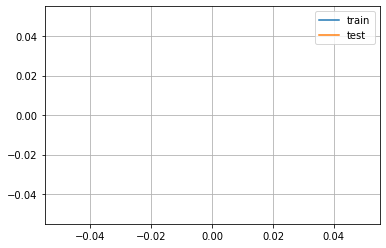

In [205]:
estimator = LGBMRegressor(boosting_type="rf", n_estimators=100)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator,
    X_train_transf,
    y_train,
    cv=KFold(n_splits=5, shuffle=True),
    scoring = make_scorer(r2_score, greater_is_better=True),
    train_sizes=np.linspace(0.1, 1.0, 10),
    return_times=True,
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)



plt.close()
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.legend()
# plt.ylim([0.5,1])
plt.grid()
plt.show()

In [204]:
train_sizes

array([ 224,  449,  673,  898, 1123, 1347, 1572, 1796, 2021, 2246])

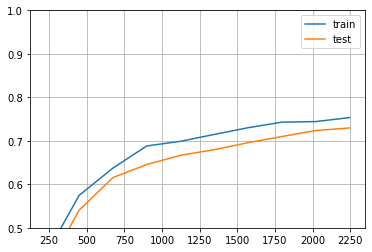

In [199]:
estimator = LGBMRegressor(reg_lambda = 1*10**3,)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    estimator,
    X_train_transf,
    y_train,
    cv=KFold(n_splits=5, shuffle=True),
    scoring = make_scorer(r2_score, greater_is_better=True),
    train_sizes=np.linspace(0.1, 1.0, 10),
    return_times=True,
)


train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)



plt.close()
plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.legend()
plt.ylim([0.5,1])
plt.grid()
plt.show()

# Modelling

In [ ]:
# generate_eda_report(X_train_fe)

# -- Hyperparameter Tunning ---------------------
tunner = HyperparameterTunner()
tunner.fit(X_train_transf, y_train)
# logg to best parameters

# -- getting best estimator -------------------
estimator = tunner.best_estimator_ 

# -- model save -------------------
update_model_artifacts(preprocessor,estimator,tunner)


mean_absolute_error(y_test, estimator.predict(X_test_transf))

In [25]:
mean_absolute_error(y_test, estimator.predict(X_test_transf))

104311.25397496909

In [12]:
np.mean(np.abs(y_test - estimator.predict(X_test_transf)))

116616.67293654206

In [13]:
temp = (
    X_test_transf
    .assign(price = y_test.values)
    .assign(price_pred = estimator.predict(X_test_transf))
    .assign(error = y_test.values-estimator.predict(X_test_transf))
)

temp['error'].abs().mean()

116616.67293654206

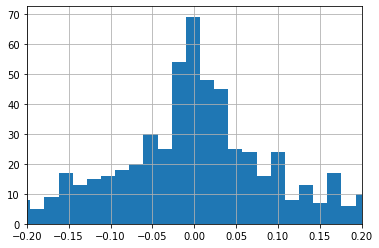

In [14]:
dist = (temp['error']/temp['price'])

dist.hist(bins=300)

plt.xlim([-0.2,0.2])
plt.show()

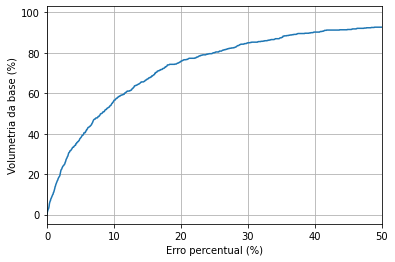

In [15]:
from scipy.stats import percentileofscore

list_ = np.array([ [i, percentileofscore(dist.abs(), i)] for i in np.arange(0,1,0.0005) ])

plt.plot(100*list_[:,0], list_[:,1])
plt.xlim([0,50])
plt.grid()
plt.xlabel('Erro percentual (%)')
plt.ylabel('Volumetria da base (%)')
plt.show()

In [19]:
estimator

GradientBoostingRegressor(learning_rate=0.07784750916224374, max_depth=6,
                          min_samples_split=4, n_estimators=500,
                          random_state=42, validation_fraction=None)

In [86]:
dist.quantile([0.1,0.9])

0.1   -0.027387
0.9    0.028515
dtype: float64

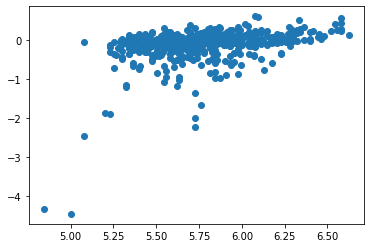

In [16]:
plt.scatter(np.log10(temp['price']), temp['error']/temp['price'])
# plt.ylim([-500000,500000])
plt.show()

In [36]:
# %%time

# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import mean_absolute_error

# estimator = GradientBoostingRegressor(
#     learning_rate=0.9,
#     max_depth=10,
#     random_state=42,
#     n_estimators=200
# )

# estimator.fit(X_train_transf, y_train)

# y_test_pred = estimator.predict(X_test_transf)
# print('MAE test:',mean_absolute_error(y_test, y_test_pred))

# y_train_pred = estimator.predict(X_train_transf)
# print('MAE train:',mean_absolute_error(y_train, y_train_pred))

In [38]:
# %%time

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

# estimator = RandomForestRegressor(
#     random_state=42
# )

# estimator.fit(X_train_transf, y_train)

# y_test_pred = estimator.predict(X_test_transf)
# print('MAE test:',mean_absolute_error(y_test, y_test_pred))

# y_train_pred = estimator.predict(X_train_transf)
# print('MAE train:',mean_absolute_error(y_train, y_train_pred))

In [26]:
np.sqrt(-tunner.best_score_)

204942.89688800712

In [27]:
tunner.best_params_

OrderedDict([('learning_rate', 0.07784750916224374),
             ('max_depth', 6),
             ('min_samples_split', 4),
             ('n_estimators', 500)])

In [43]:
from model.data.cleaning import raw_sanitize

estimator = load_pickle('models/GradientBoostingRegressor/estimator.pickle')

params = {
    "area": 195,
    "n_bathrooms": 3, #banheiros
    "n_bedrooms": 2,  #quartos
    "n_parking_spaces": 4, #garagem
    "n_suites": 1,
    "neighborhood": "Residencial Greenville",
    "type": "HOME",
    "condo_fee": np.nan,
    "iptu": np.nan,
    "latitude": np.nan,
    "longitude": np.nan,
}

X_new = pd.DataFrame(
    {
        'n_parking_spaces': [params['n_parking_spaces']],
        'n_bathrooms': [params['n_bathrooms']],
        'n_bedrooms': [params['n_bedrooms']],
        'area': [params['area']], 
        'n_suites': [params['n_suites']],
        'longitude': [params['longitude']],
        'latitude': [params['latitude']],
        'neighborhood': [params['neighborhood']],
        'condo_fee': [params['condo_fee']],
        'iptu': [params['iptu']],
        'search_date': ["2022-08-12"],
    }
)

X_new['neighborhood'] = X_new['neighborhood'].apply(str)

X_processed = (
    X_new
    .pipe(raw_sanitize)
    .pipe(add_external_data)
    .pipe(feature_engineering)
    .pipe(preprocessor.transform)
    #.pipe(estimator.predict)
)

print("Preço = {:.0f}k".format(
    estimator.predict(X_processed)[0]/1000,
    )
)

Preço = 858k


In [79]:
X_new['neighborhood'].astype(str)

0    nan
Name: neighborhood, dtype: object

552106.2151327174

483433.1484641631

631053.087276842

In [71]:
import requests
import json
url = "https://estate-predict-pc.herokuapp.com/api/predictor"
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}


r = requests.post(url, data=json.dumps(params), headers=headers)
r.json()

{'prediction': 334421.21192755195}

In [82]:
pd.DataFrame(
    {
        'feature': X_train_transf.columns,
        'importance': estimator.feature_importances_,
    }
).sort_values('importance', ascending=False)



,feature,importance
3,area,0.557549
5,neighborhood,0.232457
4,n_suites,0.077390
0,n_parking_spaces,0.020698
2,n_bedrooms,0.016299
1,n_bathrooms,0.015832
6,longitude,0.014059
7,latitude,0.010290
8,condo_fee,0.009738
9,iptu,0.008320


,area,neighborhood,n_suites,n_parking_spaces,n_bedrooms,n_bathrooms,latitude,longitude
0,100,dom_bosco,0,3,3,3,NaN,NaN
1,200,centro,1,1,1,1,NaN,NaN


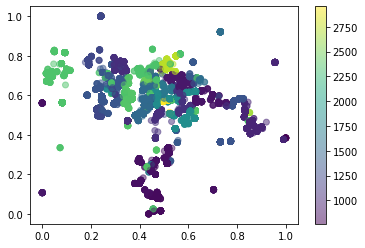

In [78]:
# plt.scatter(iris.sepal_length, iris.sepal_width, alpha = .8, c = iris.petal_length, cmap = 'seismic')
# cbar = plt.colorbar()

plt.scatter(
    X_train_transf['longitude'],
    X_train_transf['latitude'],
    c = X_train['neighbor_avg_income'],
    alpha = 0.5,
)
cbar = plt.colorbar()
plt.show()

In [70]:
X_train_transf.assign(price=y_train).corr()['neighbor_avg_income']['price']

0.0021289553871455687

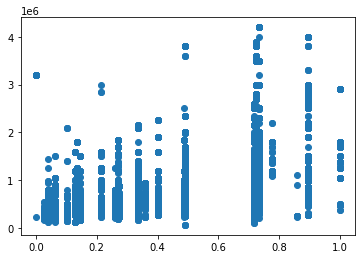

In [68]:
plt.scatter(
    X_train_transf['neighbor_avg_income'],
    y_train
)

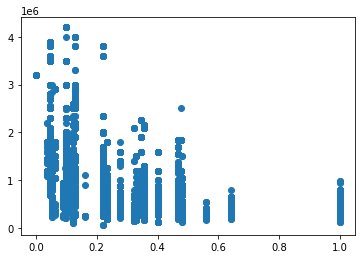

In [53]:
plt.scatter(X_train_transf['pop_2022_proj'], y_train)

plt.show()

In [55]:
X_train.head(3)

,id,type,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_suites,neighborhood,longitude,latitude,condo_fee,iptu,search_date,neighbor_region,neighbor_latitude,neighbor_longitude,pop_2000,pop_2010,pop_2022_proj,pct_domicilios_por_sal_min_0,pct_domicilios_por_sal_min_0_0.5,pct_domicilios_por_sal_min_0.5_1,pct_domicilios_por_sal_min_1_2,pct_domicilios_por_sal_min_2_5,pct_domicilios_por_sal_min_5_10,pct_domicilios_por_sal_min_10_20,pct_domicilios_por_sal_min_20_inf,neighbor_avg_income,taxa_alfabetizacao_bairro
14818,49070,HOME,0.0,1.0,2.0,76.0,0.0,jardim_sao_bento,-46.570001,-21.835916,0.0,0.0,2022-06-12 00:00:00.000000000,Região Urbana Homogênea XII,-21.835497,-46.570397,11431.0,16456.0,22486.0,0.007001,0.098020,0.231446,0.507702,0.126425,0.010202,0.001400,0.017804,855.65,95.6
8925,29711,HOME,2.0,1.0,3.0,145.0,1.0,pqe_nacoes,-46.565568,-21.850109,0.0,0.0,2022-05-01 00:00:00.000000000,Região Urbana Homogênea XIII,-21.849207,-46.564557,10436.0,11415.0,12590.0,0.006659,0.125362,0.242617,0.475680,0.109438,0.009554,0.000869,0.029820,823.98,95.3
18272,63265,HOME,3.0,2.0,4.0,230.0,1.0,parque_vivaldi_leite_ribeiro,-46.557005,-21.798239,0.0,0.0,2022-07-24 00:00:00.000000000,Região Urbana Homogênea XX,-21.813756,-46.552913,527.0,2534.0,4942.0,0.001229,0.028256,0.079853,0.377150,0.321867,0.142506,0.028256,0.020885,1836.92,99.1


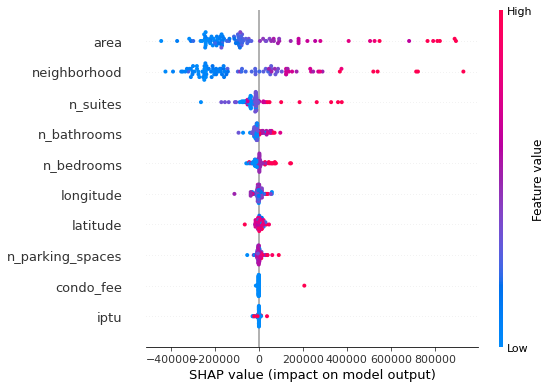

In [34]:
import shap

X_temp = X_train_transf.sample(100)

explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X_temp)

shap.summary_plot(shap_values, features=X_temp, feature_names=X_temp.columns)


In [26]:
df_neighbor = pd.read_csv(filepaths["data_external_neighbor_path"])

temp = X_train_fe.loc[~X_train_fe['neighborhood'].isin(df_neighbor["neighborhood"].to_list()), "neighborhood"]

print("size:",len(temp))

temp.value_counts()

size: 53


                                         25
residencial_e_industrial_campo_alegre    11
chacara_dos_cravos                        9
castro_e_gaiga                            2
colinas                                   1
Name: neighborhood, dtype: int64

In [17]:
df_neighbor[df_neighbor["neighborhood"].str.contains('seba')]

,neighborhood,neighbor_region,neighbor_latitude,neighbor_longitude
78,jardim_sao_sebastiao,Região Urbana Homogênea XIII,-21.858257,-46.571648
81,sao_sebastiao,Região Urbana Homogênea XIII,-21.858257,-46.571648


In [5]:
X_train_fe = feature_engineering(X_train)

In [19]:
import os
import yaml
import logging
import pandas as pd
from base.commons import load_yaml
from model.data import sanitize


REFERENCE_DATE = pd.to_datetime("2021-01-01")


def build_features(X, **kwargs):
    """ """
    X = (
        X.pipe(_decompose_date_ymd, date_column=kwargs["date_column"])
        .pipe(_add_day_of_week, date_column=kwargs["date_column"])
        .pipe(_add_passing_days)
    )

    return X


# def select(X, features):
#     """ """
#     X = X[features]
#     return X


def feature_engineering(X: pd.DataFrame) -> pd.DataFrame:
    """Applies the steps of feature engineering

    Parameters
    ----------
    X : pd.DataFrame
        Input dataframe

    Returns
    -------
    pd.DataFrame
        Dataframe with the built features
    """

    variables = load_yaml(os.getenv("VARIABLES"))

    date_column = variables["date_column"]

    X = X.pipe(sanitize).pipe(build_features, date_column=date_column)

    return X


def _decompose_date_ymd(dataframe: pd.DataFrame, date_column: str):
    """Decomposes date column into three columns of year, month and day.
    Parameters
    ----------
    dataframe : pd.DataFrame
        Pandas dataframe containing a date column.
    date_column : str
        A column containing date in datetime format.
    Returns
    -------
    pd.DataFrame
        Returns the dataframe with date decomposed into three columns.
    """

    print(date_column)

    dataframe = dataframe.assign(
        year=dataframe[date_column].dt.year,
        month=dataframe[date_column].dt.month,
        day=dataframe[date_column].dt.day,
    )

    return dataframe


def _add_day_of_week(dataframe: pd.DataFrame, date_column: str):
    """Adds a column to a dataframe containing the day of week
    correspondent to the date.
    Parameters
    ----------
    dataframe : pd.DataFrame
        Pandas dataframe containing a date column.
    date_column : str
        A column containing date in datetime format.
    Returns
    -------
    pd.DataFrame
        Returns the dataframe containing a column indicating the day of week.
    """
    week_day_order = {
        0: "Mon",
        1: "Tue",
        2: "Wed",
        3: "Thu",
        4: "Fri",
        5: "Sat",
        6: "Sun",
    }

    dataframe = dataframe.assign(
        day_of_week=dataframe[date_column].dt.dayofweek.replace(week_day_order)
    )

    return dataframe


def _add_passing_days(dataframe: pd.DataFrame):

    passing_days = (
        pd.to_datetime(dataframe["search_date"].astype("M8[ms]")) - REFERENCE_DATE
    ).dt.days

    dataframe = dataframe.assign(passing_days=passing_days)
    return dataframe


In [6]:
df.head(3)

,id,type,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_suites,state,city,neighborhood,street,longitude,latitude,condo_fee,iptu,price,search_date,neighbor_region,neighbor_latitude,neighbor_longitude,pop_2000,pop_2010,pop_2022_proj,pct_domicilios_por_sal_min_0,pct_domicilios_por_sal_min_0_0.5,pct_domicilios_por_sal_min_0.5_1,pct_domicilios_por_sal_min_1_2,pct_domicilios_por_sal_min_2_5,pct_domicilios_por_sal_min_5_10,pct_domicilios_por_sal_min_10_20,pct_domicilios_por_sal_min_20_inf,neighbor_avg_income,taxa_alfabetizacao_bairro
0,1,HOME,2.0,3.0,3.0,100.0,1.0,MG,Poços de Caldas,jardim_das_hortensias,None,NaN,NaN,NaN,NaN,420000.0,2021-06-04,Região Urbana Homogênea XX,-21.808408,-46.539132,527.0,2534.0,4942.0,0.001229,0.028256,0.079853,0.377150,0.321867,0.142506,0.028256,0.020885,1836.92,99.1
1,4,HOME,2.0,3.0,2.0,130.0,2.0,MG,Poços de Caldas,jardim_amaryllis,None,NaN,NaN,0.0,0.0,500000.0,2021-06-04,Região Urbana Homogênea XX,-21.805235,-46.541238,527.0,2534.0,4942.0,0.001229,0.028256,0.079853,0.377150,0.321867,0.142506,0.028256,0.020885,1836.92,99.1
2,5,HOME,2.0,1.0,3.0,147.0,2.0,MG,Poços de Caldas,residencial_morumbi,None,NaN,NaN,NaN,NaN,512959.0,2021-06-04,Região Urbana Homogênea VIII,-21.806827,-46.581132,6177.0,7009.0,8007.0,0.001668,0.050876,0.136781,0.404921,0.258966,0.109258,0.018349,0.019183,1501.74,98.2


In [21]:

# # Import neighbor region information
# df_neighbor = pd.read_csv(filepaths["data_external_neighbor_path"])
# df_neighbor = df_neighbor.loc[~df_neighbor["neighborhood"].duplicated()]
# data = data.merge(df_neighbor, on="neighborhood", how="left")

In [22]:
df_neighbor

,neighborhood,neighbor_region,neighbor_latitude,neighbor_longitude
0,vila_olimpica,Região Urbana Homogênea II,-21.778126,-46.606598
1,residencial_sao_bernardo,Região Urbana Homogênea III,-21.789598,-46.593153
2,residencial_mantiqueira,Região Urbana Homogênea III,-21.786012,-46.600012
3,santa_margarida,Região Urbana Homogênea III,-21.784490,-46.598762
4,bianucci,Região Urbana Homogênea III,-21.793875,-46.595109
...,...,...,...,...
180,vila_rabelo,Região Urbana Homogênea I,-21.789867,-46.640600
181,jardim_elizabete,Região Urbana Homogênea IV,-21.781738,-46.601213
182,cristiano_ozorio,Região Urbana Homogênea XIV,-21.783419,-46.562454
183,jardins_de_florenca,Região Urbana Homogênea VI,-21.809524,-46.586437


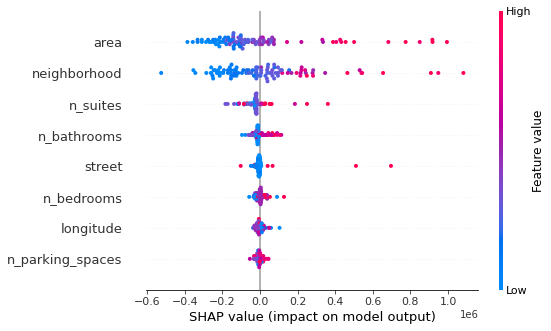

In [28]:
pd.DataFrame(
    {
        'features': X_train_transf.columns,
        'importances': estimator.feature_importances_,
    }
)


,features,importances
0,n_parking_spaces,0.021689
1,n_bathrooms,0.017895
2,n_bedrooms,0.017591
3,area,0.566073
4,n_suites,0.085599
5,neighborhood,0.231211
6,street,0.043218
7,longitude,0.016724


In [ ]:
from sklearn.feature_selection import SelectKBest

SelectKBest(score_func=<function f_classif>, *, k=10)

In [25]:
from sklearn.feature_selection import mutual_info_regression

pd.DataFrame(
    {
        'features': X_train_transf.columns,
        'mi': mutual_info_regression(X_train_transf, y_train),
    }
)

,features,mi
0,n_parking_spaces,0.509658
1,n_bathrooms,0.453399
2,n_bedrooms,0.465193
3,area,2.712398
4,n_suites,0.386809
5,neighborhood,2.108762
6,street,0.422054
7,longitude,1.854372


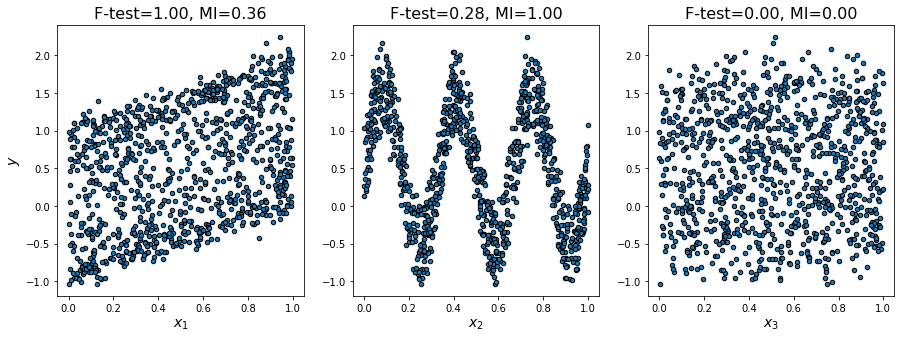

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression

np.random.seed(0)
X = np.random.rand(1000, 3)
y = X[:, 0] + np.sin(6 * np.pi * X[:, 1]) + 0.1 * np.random.randn(1000)

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X[:, i], y, edgecolor="black", s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("F-test={:.2f}, MI={:.2f}".format(f_test[i], mi[i]), fontsize=16)

In [23]:
f_test

array([1.        , 0.28024353, 0.00252204])

In [22]:
mi

array([0.36448455, 1.        , 0.        ])

In [ ]:
def score_function(X, y):

    return 

<AxesSubplot:>

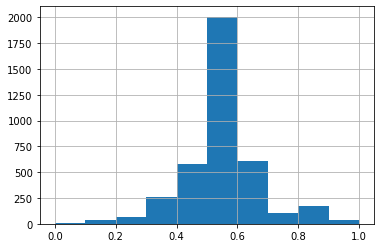

In [13]:
X_test_transf['longitude'].hist()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
estimator_name = variables["estimator"]

model_artifacts = {
    "model": variables["estimator"],
    "metric": {
        "name": tunner.search_scoring,
        "value": tunner.best_score_,
    },
    "hyper_params": tunner.best_params_
}


estimator_name

'RandomForestRegressor'

In [8]:
%%bash
ls

config
data
docs
environment.yml
logs
models
notebooks
README.md
references
reports
requirements.txt
src


In [6]:
# def update_metadata_store(tunner):

#     filepaths = load_yaml(os.getenv("FILEPATHS"))

#     variables = load_yaml(os.getenv("VARIABLES"))


#     metadata_filepath = os.path.join(
#         filepaths['model_artifacts_path'],
#         variables['metadata_store_filename'],
#     )

#     if os.path.exists(metadata_filepath):
#         metadata_store = pd.read_json(metadata_filepath)
#         last_model = metadata_store.iloc[-1].to_dict()
#         version = last_model['version']
#         subversion = last_model['subversion']
#         identifier = last_model['identifier'] + 1
#     else:
#         metadata_store = pd.DataFrame()
#         version = 0
#         subversion = 0
#         identifier = 1

#     model_metadata = [
#         {
#             'version': version,
#             'subversion': subversion,
#             'identifier': identifier + 1,
#             'estimator': variables["estimator"],
#             'metric_name': tunner.search_scoring,
#             'metric_score': tunner.best_score_,
#         }
#     ]

#     updated_model_metadata = pd.concat(
#         [
#             metadata_store,
#             pd.DataFrame(model_metadata),
#         ]
#     ).reset_index(drop=True)


#     dump_json(
#         updated_model_metadata.to_dict(orient='records'),
#         'models/metadata_store_2.json',
#         indent=2,
#     )

[{'version': 0,
  'subversion': 0,
  'identifier': 2,
  'estimator': 'RandomForestRegressor',
  'metric_name': 'neg_mean_squared_error',
  'metric_score': -5217793788.150981}]

In [16]:


# updated_metadata.to_json('models/metadata_store_2.json')


'models/metadata_store.json'

In [53]:
updated_metadata.reset_index(drop=True)

,version,subversion,identifier,estimator,metric_name,metric_score
0,0,0,0,RandomForestRegressor,neg_mean_squared_error,-5.194679e+09
1,0,0,2,RandomForestRegressor,neg_mean_squared_error,-5.194679e+09


In [6]:
tunner.best_estimator_

RandomForestRegressor(max_depth=21, n_estimators=95, random_state=42)

In [12]:
tunner.search_strategy

'RandomizedSearch'

## Estudo de features

In [5]:
supervised_test_rf(X_train_transf, X_test_transf, y_train, y_test)

2022-08-05 23:38:19,400 [INFO] cv_mae_score = 18654 ± 903
2022-08-05 23:38:21,302 [INFO] MAE (train) = 8369.385
2022-08-05 23:38:21,394 [INFO] MAE (test) = 18265.590
2022-08-05 23:38:21,602 [INFO] R2 (train) = 0.998
2022-08-05 23:38:21,689 [INFO] R2 (test) = 0.986


In [14]:
supervised_test_lgmb(X_train_transf, X_test_transf, y_train, y_test)

2022-08-05 23:43:14,635 [INFO] cv_mae_score = 77338 ± 2569
2022-08-05 23:43:14,791 [INFO] MAE (train) = 69745.199
2022-08-05 23:43:14,827 [INFO] MAE (test) = 77487.170
2022-08-05 23:43:14,880 [INFO] R2 (train) = 0.968
2022-08-05 23:43:14,902 [INFO] R2 (test) = 0.958


In [13]:
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def supervised_test_lgmb(X_train, X_test, y_train, y_test, random_state=42):

    regressor = TransformedTargetRegressor(
        regressor=LGBMRegressor(random_state=random_state),
        func=lambda x: x,
        inverse_func=lambda x: x,
    )

    cv_results = cross_validate(
        regressor, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
    )

    cv_scores = -np.array(cv_results["test_score"])

    logging.info(
        "cv_mae_score = {:.0f} ± {:.0f}".format(np.mean(cv_scores), np.std(cv_scores))
    )

    regressor.fit(X_train, y_train)

    logging.info(
        "MAE (train) = {:.3f}".format(
            mean_absolute_error(y_train, regressor.predict(X_train))
        )
    )
    logging.info(
        "MAE (test) = {:.3f}".format(
            mean_absolute_error(y_test, regressor.predict(X_test))
        )
    )
    logging.info(
        "R2 (train) = {:.3f}".format(r2_score(y_train, regressor.predict(X_train)))
    )
    logging.info(
        "R2 (test) = {:.3f}".format(r2_score(y_test, regressor.predict(X_test)))
    )


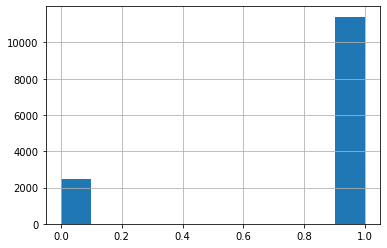

2022-08-04 23:42:26,833 [INFO] quantiles = 
   quantiles  year
0       0.00   0.0
1       0.50   1.0
2       0.95   1.0
3       0.99   1.0
2022-08-04 23:42:26,836 [INFO] skewness =  -1.690
2022-08-04 23:42:26,838 [INFO] kurtosis = 0.870
2022-08-04 23:42:26,840 [INFO] target corr. = 0.038
2022-08-04 23:42:27,694 [INFO] cv_mae_score = 418773 ± 4406
2022-08-04 23:42:27,905 [INFO] MAE (train) = 418759.798
2022-08-04 23:42:27,928 [INFO] MAE (test) = 429105.995
2022-08-04 23:42:27,971 [INFO] R2 (train) = 0.001
2022-08-04 23:42:27,986 [INFO] R2 (test) = 0.003


In [28]:
column_name = 'year'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


In [5]:
column_name = 'latitude'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


KeyError: 'latitude'

In [32]:
# column_name = 'longitude'

# column = X_train_transf[column_name]
# column.hist()
# plt.show()
# logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
# logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
# logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

# logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
# supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


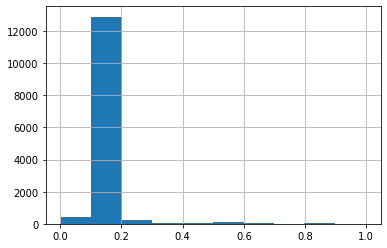

2022-08-04 23:21:51,537 [INFO] quantiles = 
   quantiles    street
0       0.00  0.002069
1       0.50  0.168470
2       0.95  0.170922
3       0.99  0.535286
2022-08-04 23:21:51,538 [INFO] skewness =  6.580
2022-08-04 23:21:51,540 [INFO] kurtosis = 57.740
2022-08-04 23:21:51,541 [INFO] target corr. = 0.407
2022-08-04 23:21:52,836 [INFO] cv_mae_score = 369018 ± 5608
2022-08-04 23:21:53,139 [INFO] MAE (train) = 368141.264
2022-08-04 23:21:53,174 [INFO] MAE (test) = 378541.899
2022-08-04 23:21:53,249 [INFO] R2 (train) = 0.168
2022-08-04 23:21:53,276 [INFO] R2 (test) = 0.165


In [16]:
column_name = 'street'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


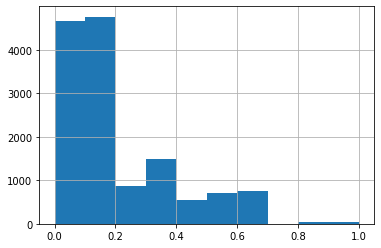

2022-08-04 23:22:01,486 [INFO] quantiles = 
   quantiles  neighborhood
0       0.00      0.000000
1       0.50      0.154463
2       0.95      0.609327
3       0.99      0.635144
2022-08-04 23:22:01,487 [INFO] skewness =  1.290
2022-08-04 23:22:01,489 [INFO] kurtosis = 1.150
2022-08-04 23:22:01,491 [INFO] target corr. = 0.774
2022-08-04 23:22:03,237 [INFO] cv_mae_score = 223995 ± 3200
2022-08-04 23:22:03,680 [INFO] MAE (train) = 222449.364
2022-08-04 23:22:03,730 [INFO] MAE (test) = 222725.657
2022-08-04 23:22:03,837 [INFO] R2 (train) = 0.600
2022-08-04 23:22:03,885 [INFO] R2 (test) = 0.621


In [17]:
column_name = 'neighborhood'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


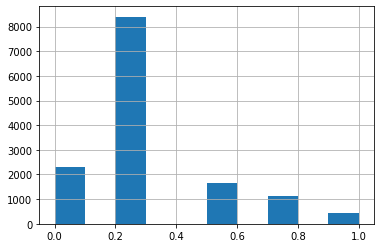

2022-08-04 23:22:09,776 [INFO] quantiles = 
   quantiles  n_suites
0       0.00      0.00
1       0.50      0.25
2       0.95      0.75
3       0.99      1.00
2022-08-04 23:22:09,778 [INFO] skewness =  1.170
2022-08-04 23:22:09,780 [INFO] kurtosis = 1.420
2022-08-04 23:22:09,782 [INFO] target corr. = 0.586
2022-08-04 23:22:10,668 [INFO] cv_mae_score = 317321 ± 4250
2022-08-04 23:22:10,896 [INFO] MAE (train) = 317188.773
2022-08-04 23:22:10,922 [INFO] MAE (test) = 318865.594
2022-08-04 23:22:10,965 [INFO] R2 (train) = 0.390
2022-08-04 23:22:10,990 [INFO] R2 (test) = 0.416


In [18]:
column_name = 'n_suites'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


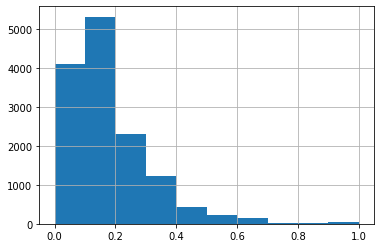

2022-08-04 23:22:13,805 [INFO] quantiles = 
   quantiles      area
0       0.00  0.000000
1       0.50  0.145029
2       0.95  0.429615
3       0.99  0.655824
2022-08-04 23:22:13,809 [INFO] skewness =  2.020
2022-08-04 23:22:13,813 [INFO] kurtosis = 6.030
2022-08-04 23:22:13,817 [INFO] target corr. = 0.766
2022-08-04 23:22:17,916 [INFO] cv_mae_score = 151488 ± 2503
2022-08-04 23:22:18,789 [INFO] MAE (train) = 145769.055
2022-08-04 23:22:18,848 [INFO] MAE (test) = 158645.387
2022-08-04 23:22:18,990 [INFO] R2 (train) = 0.822
2022-08-04 23:22:19,050 [INFO] R2 (test) = 0.795


In [19]:
column_name = 'area'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


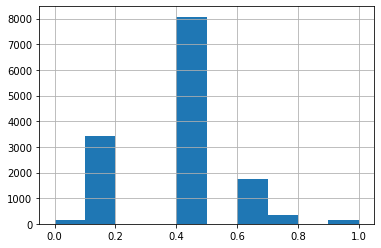

2022-08-04 23:22:19,267 [INFO] quantiles = 
   quantiles  n_bedrooms
0       0.00         0.0
1       0.50         0.4
2       0.95         0.6
3       0.99         1.0
2022-08-04 23:22:19,271 [INFO] skewness =  0.820
2022-08-04 23:22:19,273 [INFO] kurtosis = 2.070
2022-08-04 23:22:19,275 [INFO] target corr. = 0.544
2022-08-04 23:22:20,256 [INFO] cv_mae_score = 321798 ± 3898
2022-08-04 23:22:20,471 [INFO] MAE (train) = 321660.127
2022-08-04 23:22:20,498 [INFO] MAE (test) = 325172.015
2022-08-04 23:22:20,543 [INFO] R2 (train) = 0.335
2022-08-04 23:22:20,569 [INFO] R2 (test) = 0.345


In [20]:
column_name = 'n_bedrooms'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95,0.99]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


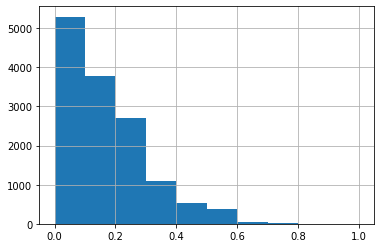

2022-08-04 23:22:20,753 [INFO] quantiles = 
   quantiles  n_bathrooms
0       0.00     0.000000
1       0.50     0.163171
2       0.95     0.442114
2022-08-04 23:22:20,755 [INFO] skewness =  0.530
2022-08-04 23:22:20,756 [INFO] kurtosis = -0.550
2022-08-04 23:22:20,758 [INFO] target corr. = 0.547
2022-08-04 23:22:21,724 [INFO] cv_mae_score = 312095 ± 4695
2022-08-04 23:22:21,951 [INFO] MAE (train) = 311841.925
2022-08-04 23:22:21,980 [INFO] MAE (test) = 313481.828
2022-08-04 23:22:22,033 [INFO] R2 (train) = 0.385
2022-08-04 23:22:22,066 [INFO] R2 (test) = 0.382


In [21]:
column_name = 'n_bathrooms'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


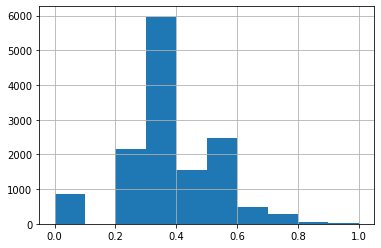

2022-08-04 23:22:22,262 [INFO] quantiles = 
   quantiles  n_parking_spaces
0       0.00          0.000000
1       0.50          0.360849
2       0.95          0.639151
2022-08-04 23:22:22,264 [INFO] skewness =  -0.230
2022-08-04 23:22:22,266 [INFO] kurtosis = 0.960
2022-08-04 23:22:22,268 [INFO] target corr. = 0.409
2022-08-04 23:22:23,249 [INFO] cv_mae_score = 344512 ± 2678
2022-08-04 23:22:23,481 [INFO] MAE (train) = 344025.662
2022-08-04 23:22:23,504 [INFO] MAE (test) = 348835.545
2022-08-04 23:22:23,560 [INFO] R2 (train) = 0.282
2022-08-04 23:22:23,583 [INFO] R2 (test) = 0.294


In [22]:
column_name = 'n_parking_spaces'

column = X_train_transf[column_name]
column.hist()
plt.show()
logging.info("quantiles = \n" + str((column.quantile([0,0.5,0.95]).to_frame().reset_index()).rename(columns = {'index': 'quantiles'})))
logging.info("skewness =  {:.3f}".format(column.skew().round(2)))
logging.info("kurtosis = {:.3f}" .format(column.kurtosis().round(2)))

logging.info("target corr. = {:.3f}" .format(np.corrcoef(column, y_train)[0][1]))
supervised_test_rf(X_train_transf[[column_name]], X_test_transf[[column_name]], y_train, y_test)


In [112]:
supervised_test_rf(X_train_transf, X_test_transf, y_train, y_test)

2022-08-04 14:50:57,958 [INFO] MAE (train) = 11843.756
2022-08-04 14:50:58,041 [INFO] MAE (test) = 20833.289
2022-08-04 14:50:58,240 [INFO] R2 (train) = 0.995
2022-08-04 14:50:58,326 [INFO] R2 (test) = 0.980


In [52]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


regressor = RandomForestRegressor().fit(X_train_transf, y_train)


mean_absolute_error(y_test,regressor.predict(X_test_transf))

22647.948609947973

<AxesSubplot:>

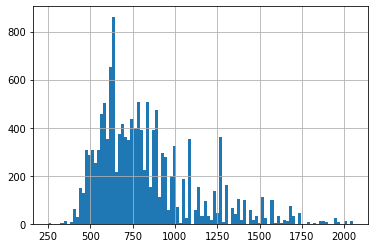

In [47]:
np.sqrt(y_train).hist(bins=100)

In [22]:
np.linspace(y_train.min(), y_train.max(),11)

array([  64000.,  477600.,  891200., 1304800., 1718400., 2132000.,
       2545600., 2959200., 3372800., 3786400., 4200000.])

In [18]:
pd.cut(y_train, 10)

57055      (477600.0, 891200.0]
44710       (59864.0, 477600.0]
15487       (59864.0, 477600.0]
40997      (477600.0, 891200.0]
38495       (59864.0, 477600.0]
                  ...          
37104    (1304800.0, 1718400.0]
39550      (477600.0, 891200.0]
18052    (1718400.0, 2132000.0]
3056        (59864.0, 477600.0]
51605    (1718400.0, 2132000.0]
Name: price, Length: 13870, dtype: category
Categories (10, interval[float64]): [(59864.0, 477600.0] < (477600.0, 891200.0] < (891200.0, 1304800.0] < (1304800.0, 1718400.0] ... (2545600.0, 2959200.0] < (2959200.0, 3372800.0] < (3372800.0, 3786400.0] < (3786400.0, 4200000.0]]

In [31]:
import yaml
from io import StringIO

EXAMPLE_HEADER = """
###################################################
# FEATURES - CONFIGURATION EXAMPLE
#
# >>> Example:
# - name: nome_da_feature
#   active: true
#   type: float
#   imputation_strategy: constant # (constant, mean, median)
#   imputation_fill_value: 1 # only applicable to constant strategy
#   limits: [0.0, 1705.0] # if set limits, do not set qlimits
#   qlimits: [0,0.95] # quantile limts; if set qlimits, do not set limits
#   transformation: identity # (log, log10, log1p, exp, square, sqrt, identity)
#   discretizer_n_bins: null
#   discretizer_encode: "ordinal" # (ordinal, onehot)
#   discretizer_strategy: quantile # (uniform, quantile, kmeans)
#   encoder: m_estimate # (onehot, woe, target, sum, m_estimate, leave_one_out, helmert, cat_boost, james_stein)
#   scaler: minmax #(minmax, standard, robust)

"""

def generate_features_config_example(df, filepath):
    
    obj = [
        {
            'name': col,
            'type': 'float',
            'active': True,
            'encode': None,
            'imputation_strategy': 'median',
            'imputation_fill_value': 0,
            'qlimits': [0,1],
            'limits': None,
            'transformation': 'log1p',
            'discretizer_n_bins': None,
            'discretizer_encode': "ordinal",
            'discretizer_strategy': "quantile",
            'scale': "minmax",
        }

        for col in df
    ]
    
    output = StringIO()

    yaml.dump(obj, output, sort_keys=False)

    text = EXAMPLE_HEADER + output.getvalue().replace('\n- ', '\n\n- ')

    with open(filepath, 'w') as file:
        file.write(text)


# from base.commons import dump_yaml

# dump_yaml(obj, 'config/features_example.yaml')



# assert (kwargs['qlimits'] is None) | (kwargs['limits'] is None)  

In [32]:
generate_features_config_example(X_train_transf, 'config/features_example.yaml')

In [18]:
filepath = 'config/features_example.yaml'

obj = [
    {
        'name': col,
        'type': 'float',
        'active': True,
        'encode': None,
        'imputation_strategy': 'median',
        'imputation_fill_value': 0,
        'qlimits': [0,1],
        'limits': None,
        'transformation': 'log1p',
        'discretizer_n_bins': None,
        'discretizer_encode': "ordinal",
        'discretizer_strategy': "quantile",
        'scale': "minmax",
    }

    for col in X_train_transf
]


In [29]:
filepath

'config/features_example.yaml'

# Sandbox

In [128]:
import os
import yaml
import logging
import pandas as pd
import numpy as np
from unidecode import unidecode


from dotenv import load_dotenv
from sqlalchemy import create_engine
from basix.parquet import write as to_parquet

from base.commons import load_yaml
from src.model.data.cleaning import raw_sanitize


EXTRACTION_QUERY = """\
WITH tab AS (
    SELECT
        id
        , search_date
        , type
        , n_parking_spaces
        , n_bathrooms
        , n_bedrooms
        , area
        , n_suites
        , neighborhood
        , CASE WHEN ABS(longitude) > 0 THEN longitude ELSE NULL END as longitude
        , CASE WHEN ABS(latitude) > 0 THEN latitude ELSE NULL END as latitude
        , condo_fee
        , iptu
        , price     
    FROM pocos_de_caldas.imoveis i
    WHERE True
      AND price IS NOT NULL
      AND price > 0
) SELECT * FROM tab t
"""


def extract_scrapped_relational_data() -> None:
    """Extract relational data from PostgreSQl database and
    persists in a local parquet file.
    """

    assert load_dotenv()

    # --
    logging.info("Importing variables")
    filepaths = load_yaml(os.getenv("FILEPATHS"))
    variables = load_yaml(os.getenv("VARIABLES"))

    # --
    logging.info("Setting postgresql connection")
    engine = create_engine(
        "postgresql://{user}:{password}@{host}:{port}/{database}".format(
            user=os.getenv("DB_USERNAME"),
            password=os.getenv("DB_PASSWORD"),
            host=os.getenv("DB_HOST"),
            port=os.getenv("DB_PORT"),
            database=os.getenv("DB_NAME"),
        )
    )

    # --
    logging.info("Reading data from PostgreSQl")
    df_basic = pd.read_sql(EXTRACTION_QUERY, engine)

    # --
    df_basic = df_basic.pipe(raw_sanitize)

    # --
    logging.info("Persisting relational raw data")
    to_parquet(
        df_basic,
        filepaths["raw_data_relational_scrapped"],
        overwrite=True,
        partition_cols=["search_date"],
    )

In [129]:
assert load_dotenv()

# --
logging.info("Importing variables")
filepaths = load_yaml(os.getenv("FILEPATHS"))
variables = load_yaml(os.getenv("VARIABLES"))

# --
logging.info("Setting postgresql connection")
engine = create_engine(
    "postgresql://{user}:{password}@{host}:{port}/{database}".format(
        user=os.getenv("DB_USERNAME"),
        password=os.getenv("DB_PASSWORD"),
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        database=os.getenv("DB_NAME"),
    )
)

2022-08-19 22:06:41,902 [INFO] Importing variables
2022-08-19 22:06:41,909 [INFO] Setting postgresql connection


In [132]:
# query = "select * from pocos_de_caldas.imoveis"

# df_basic = pd.read_sql(query, engine)

df_basic.head(2)

,id,search_id,id_zap,search_date,type,n_parking_spaces,n_bathrooms,n_bedrooms,area,n_floors,units_on_floor,n_suites,state,city,neighborhood,street,longitude,latitude,price,condo_fee,iptu,resale,buildings,plan_only,amenities,pois_list,link,description
0,1,2503300374__2021_06_04_00_23_37,2503300374,2021-06-04,HOME,2.0,3.0,3.0,100.0,NaN,0,1.0,MG,Poços de Caldas,Jardim Das Hortênsias,None,NaN,NaN,420000.0,NaN,NaN,0,0,0,[],"[{'name': 'Colégio Pelicano - Ensino Médio', '...",/imovel/venda-casa-3-quartos-jardim-das-horten...,Casa no Jardim das Hortênsias- Poços de Caldas...
1,2,2462358530__2021_06_04_00_23_37,2462358530,2021-06-04,APARTMENT,2.0,3.0,3.0,128.0,NaN,0,1.0,MG,Poços de Caldas,Centro,Rua Assis Figueiredo,-46.56683,-21.780617,950000.0,0.0,0.0,0,0,0,"[GATED_COMMUNITY, ELEVATOR, SERVICE_AREA, BALC...","[{'name': 'Mirian’s', 'class': 'BR'}, {'name':...",/imovel/venda-apartamento-3-quartos-centro-poc...,Apartamento na Rua Assis Figueiredo de aproxim...
